In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
import glob as glob
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from scipy.stats import spearmanr
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

### Load consolidated dimreduc dataframe

In [2]:
path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_dimreduc_param_search/degraded_dimreduc_param_search_glom.pickle'
with open(path, 'rb') as f:
    dat = pickle.load(f) 

df_dimreduc = pd.DataFrame(dat)

### Load CCA model

In [3]:
ccamodel_dir = df_dimreduc['results_file'][0]
CCA_dims = 25 #None

if CCA_dims == None:
    ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]
else:
    ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{CCA_dims}_dims.pickle"

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)




### Some useful values

In [4]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])

In [5]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
importance_scores = recursive_defaultdict()



for reg in regions:
    if reg == 'ML':
        cca_proj = ccamodel.x_rotations_
    else:
        cca_proj = ccamodel.y_rotations_

    for dim in dimensions:

        importance_scores[reg]['CCA'][dim] = calc_loadings(cca_proj[:, 0:dim])
        
        for method in dimreduc_methods:    
            all_scores = np.zeros((len(n_folds), cca_proj.shape[0]))

            for n_fold in n_folds:

                coef = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == reg)  & 
                                            (df_dimreduc['dim'] == dim) & (df_dimreduc['fold_idx'] == n_fold) &
                                            (df_dimreduc['dimreduc_method'] == method)]['coef'].iloc[0]
                
                all_scores[n_fold, :] = calc_loadings(coef)

            importance_scores[reg][method][dim] = np.mean(all_scores, 0)



## Visualizing unit importance across subspaces

#### Area ML

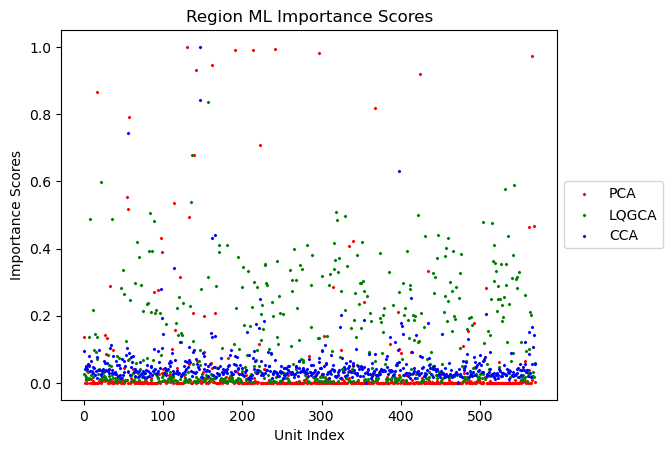

In [6]:
DIM = 25  

region = 'ML'

numUnits = ccamodel.x_rotations_.shape[0]  
xVals = np.arange(numUnits)

# Corrected scatter function usage
plt.scatter(xVals, importance_scores[region]['PCA'][DIM], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()


In [12]:
DIM = 25  
region = 'ML'


x = importance_scores[region]['PCA'][DIM]
y = importance_scores[region]['LQGCA'][DIM]
z = importance_scores[region]['CCA'][DIM]

init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Scatter3d( x=x, y=y,  z=z,
                                    mode='markers', marker=dict( size=5, color='blue', opacity=0.8 ) )])

fig.update_layout( scene=dict( xaxis=dict(title='FFC'), yaxis=dict(title='FBC', autorange='reversed'),  zaxis=dict(title='CCA'),
                    camera=dict(eye=dict(x=1.25, y=1.25, z=1.25)) ), title=f'Region {region} importance scores', height=500 )


fig.show()
#iplot(fig)


In [ ]:
### CODE TO MAKE A MOVIE OF THE ABOVE PLOT
import imageio

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color='blue',    # static color
        opacity=0.8
    )
)])

# Add titles
fig.update_layout(
    scene=dict(
        xaxis_title='FFC',
        yaxis_title='FBC',
        zaxis_title='CCA'
    ),
    title='Interactive 3D Scatter Plot',
    height=700  # Set the height of the plot
)

# Function to capture frames at different angles
def capture_frames(fig, steps=36):
    frames = []
    for angle in np.linspace(0, 360, steps):
        fig.update_layout(scene_camera_eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)), z=0.5))
        img_bytes = fig.to_image(format="png")
        frames.append(imageio.imread(img_bytes))
    return frames

# Capture frames and create a video
#frames = capture_frames(fig)
#imageio.mimsave('3d_scatter_rotation.gif', frames, fps=10)

# To create a video file instead of a GIF, use the following line:
# imageio.mimsave('3d_scatter_rotation.mp4', frames, fps=10, codec='libx264')


/tmp/ipykernel_167576/1497422774.py:33: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



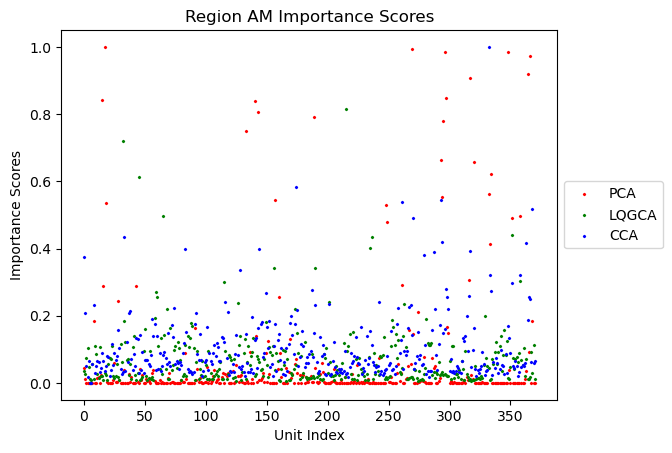

In [9]:
DIM = 25  
region = 'AM'

numUnits = ccamodel.y_rotations_.shape[0]  
xVals = np.arange(numUnits)

# Corrected scatter function usage
plt.scatter(xVals, importance_scores[region]['PCA'][DIM], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()


In [11]:
DIM = 25  
region = 'AM'


x = importance_scores[region]['PCA'][DIM]
y = importance_scores[region]['LQGCA'][DIM]
z = importance_scores[region]['CCA'][DIM]

init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Scatter3d( x=x, y=y,  z=z,
                                    mode='markers', marker=dict( size=5, color='blue', opacity=0.8 ) )])

fig.update_layout( scene=dict( xaxis=dict(title='FFC'), yaxis=dict(title='FBC', autorange='reversed'),  zaxis=dict(title='CCA'),
                    camera=dict(eye=dict(x=1.25, y=1.25, z=1.25)) ), title=f'Region {region} importance scores', height=500 )


fig.show()
#iplot(fig)


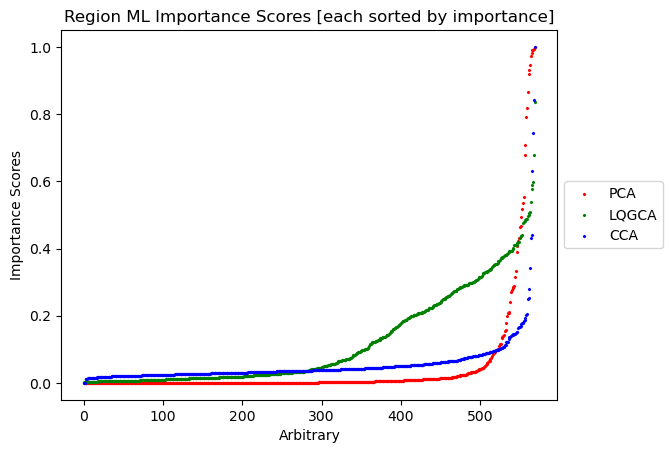

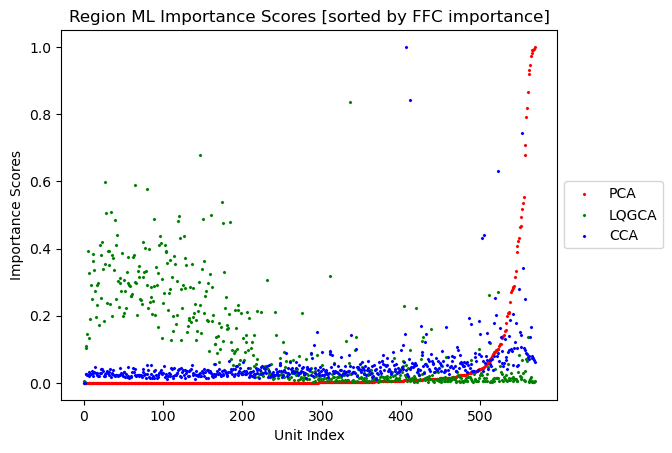

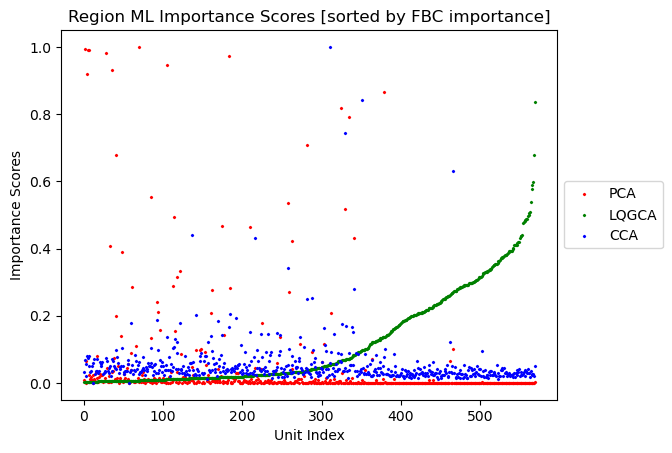

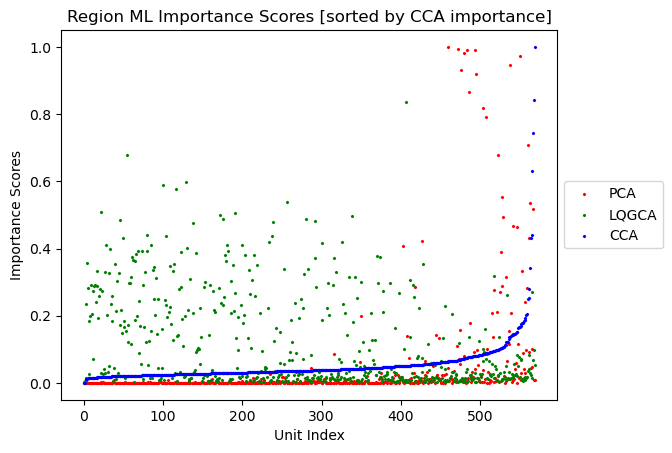

In [9]:
region = 'ML'
DIM = 25  

numUnits = ccamodel.x_rotations_.shape[0]  
xVals = np.arange(numUnits)

plt.scatter(xVals, np.sort(importance_scores[region]['PCA'][DIM]), marker='x', s=2, color='r')
plt.scatter(xVals, np.sort(importance_scores[region]['LQGCA'][DIM]), marker='x', s=2, color='g')
plt.scatter(xVals, np.sort(importance_scores[region]['CCA'][DIM]), marker='x', s=2, color='b')


plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [each sorted by importance]')
plt.xlabel('Arbitrary')  
plt.ylabel('Importance Scores')
plt.show()


inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FFC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

#inds = np.argsort(importance_scores[region]['PCA'][DIM])
inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FBC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

#inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by CCA importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

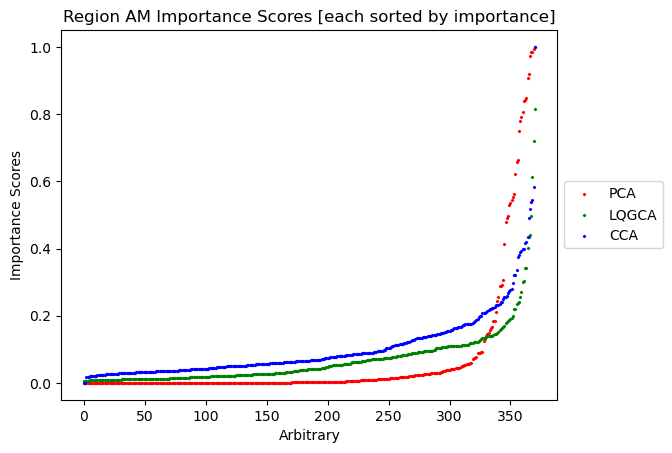

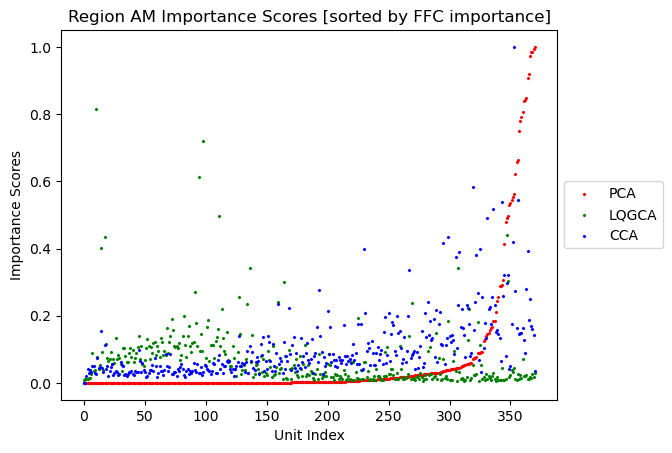

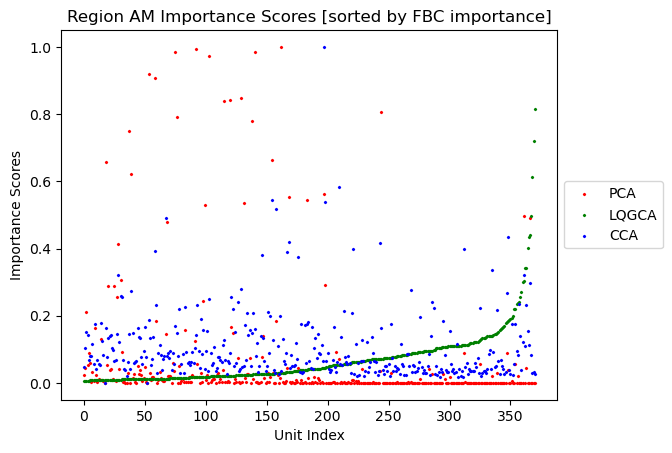

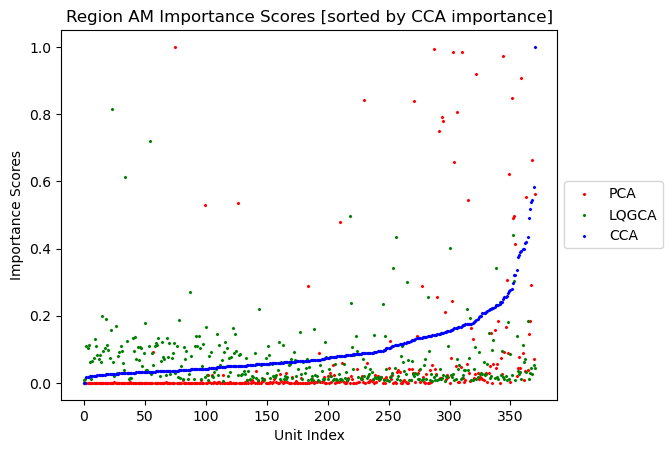

In [10]:
region = 'AM'
DIM = 25  


numUnits = ccamodel.y_rotations_.shape[0]  
xVals = np.arange(numUnits)

plt.scatter(xVals, np.sort(importance_scores[region]['PCA'][DIM]), marker='x', s=2, color='r')
plt.scatter(xVals, np.sort(importance_scores[region]['LQGCA'][DIM]), marker='x', s=2, color='g')
plt.scatter(xVals, np.sort(importance_scores[region]['CCA'][DIM]), marker='x', s=2, color='b')


plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [each sorted by importance]')
plt.xlabel('Arbitrary')  
plt.ylabel('Importance Scores')
plt.show()


inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FFC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

#inds = np.argsort(importance_scores[region]['PCA'][DIM])
inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
#inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by FBC importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()


#inds = np.argsort(importance_scores[region]['PCA'][DIM])
#inds = np.argsort(importance_scores[region]['LQGCA'][DIM])
inds = np.argsort(importance_scores[region]['CCA'][DIM])

plt.scatter(xVals, importance_scores[region]['PCA'][DIM][inds], marker='x', s=2, color='r')
plt.scatter(xVals, importance_scores[region]['LQGCA'][DIM][inds], marker='x', s=2, color='g')
plt.scatter(xVals, importance_scores[region]['CCA'][DIM][inds], marker='x', s=2, color='b')

plt.legend(['PCA', 'LQGCA', 'CCA'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Region {region} Importance Scores [sorted by CCA importance]')
plt.xlabel('Unit Index')  
plt.ylabel('Importance Scores')
plt.show()

In [11]:
ML_FFC_sum = np.sum(importance_scores['ML']['PCA'][np.max(dimensions)])
ML_FBC_sum = np.sum(importance_scores['ML']['LQGCA'][np.max(dimensions)])
ML_CCA_sum = np.sum(importance_scores['ML']['CCA'][np.max(dimensions)])

AM_FFC_sum = np.sum(importance_scores['AM']['PCA'][np.max(dimensions)])
AM_FBC_sum = np.sum(importance_scores['AM']['LQGCA'][np.max(dimensions)])
AM_CCA_sum = np.sum(importance_scores['AM']['CCA'][np.max(dimensions)])


print(f"ML FFC total importance: {ML_FFC_sum}")
print(f"ML FBC total importance: {ML_FBC_sum}")
print(f"ML CCA total importance: {ML_CCA_sum}")
print()
print(f"AM FFC total importance: {AM_FFC_sum}")
print(f"AM FBC total importance: {AM_FBC_sum}")
print(f"AM CCA total importance: {AM_CCA_sum}")



ML FFC total importance: 69.44095562838982
ML FBC total importance: 75.60419521466679
ML CCA total importance: 31.277706246066714

AM FFC total importance: 69.47733026727295
AM FBC total importance: 69.558385744612
AM CCA total importance: 38.84048806289003


In [12]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
subspace_importance_correlations = recursive_defaultdict()
subspace_importance_pvals = recursive_defaultdict()

proj_methods = np.append(dimreduc_methods, 'CCA')

for region in regions:
    region_method_pairs = set()  # Set to keep track of seen combinations
    if region == 'AM':
        DIM = 39
    elif region == 'ML':
        DIM = 21

    for method0, method1 in itertools.product(proj_methods, proj_methods):
        sorted_0 = tuple(sorted([region, method0]))
        sorted_1 = tuple(sorted([region, method1]))
        
        combo = (tuple(sorted((sorted_0, sorted_1))))
        
        if combo in region_method_pairs:
            continue  
        elif method0 == method1:
            continue
        region_method_pairs.add(combo)



        scores0 = importance_scores[region][method0][DIM]
        scores1 = importance_scores[region][method1][DIM]

        corrs, pvals = spearmanr(scores0, scores1 ) 

        subspace_importance_correlations[region][f"{method0}_{method1}"] = corrs
        subspace_importance_pvals[region][f"{method0}_{method1}"] = pvals


In [13]:
AM_corrs = np.array(list(subspace_importance_correlations['AM'].values()))
ML_corrs = np.array(list(subspace_importance_correlations['ML'].values()))
comparisons = np.array(list(subspace_importance_correlations['AM'].keys()))

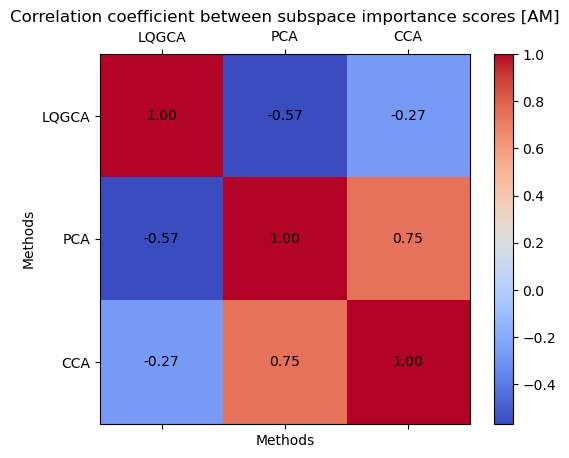

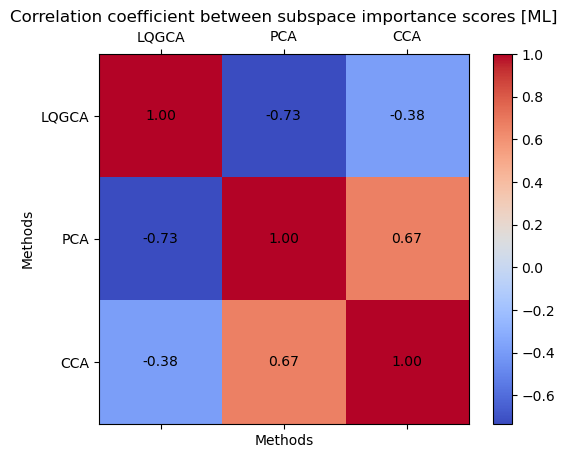

In [14]:
methods = proj_methods
indices = {name: i for i, name in enumerate(proj_methods)}

# Function to create a heatmap from correlations
def create_heatmap(corrs, comparisons, methods, region):
    # Initialize a 3x3 matrix of NaNs
    matrix = np.full((3, 3), np.nan)
    
    # Fill the matrix with correlations
    for comp, corr in zip(comparisons, corrs):
        m1, m2 = comp.split('_')
        i, j = indices[m1], indices[m2]
        matrix[i, j] = corr
        matrix[j, i] = corr  # Mirror the value
    
    # Diagonal (comparison of the method with itself)
    for i in range(3):
        matrix[i, i] = 1.0  # Perfect correlation with itself
    
    # Plotting
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='coolwarm')
    plt.colorbar(cax)
    ax.set_xticks(range(len(methods)))
    ax.set_yticks(range(len(methods)))
    ax.set_xticklabels(methods)
    ax.set_yticklabels(methods)

    for (i, j), val in np.ndenumerate(matrix):
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

    plt.title(f'Correlation coefficient between subspace importance scores [{region}]')
    plt.xlabel('Methods')
    plt.ylabel('Methods')
    plt.show()

create_heatmap(AM_corrs, comparisons, proj_methods, 'AM')
create_heatmap(ML_corrs, comparisons, proj_methods, 'ML')
